# Logo2k+ EDA and Visualization

## Loading and exploring data

In [1]:
import os

from dotenv import load_dotenv

load_dotenv("../.env")

dataset_folder = os.environ["DATASET_FOLDER"]

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from pathlib import Path

p = Path(dataset_folder)

images = [child.relative_to(dataset_folder) for child in p.glob("**/*.jpg")]

df = pd.DataFrame([image.parts for image in images], columns=["type", "brand", "id"])

In [4]:
df.head()

,type,brand,id
0,Accessories,24seven,28.jpg
1,Accessories,24seven,47.jpg
2,Accessories,24seven,1.jpg
3,Accessories,24seven,10.jpg
4,Accessories,24seven,11.jpg


In [5]:
df.tail()

,type,brand,id
167135,Transportation,Yamaha,85.jpg
167136,Transportation,Yamaha,86.jpg
167137,Transportation,Yamaha,87.jpg
167138,Transportation,Yamaha,88.jpg
167139,Transportation,Yamaha,9.jpg


In [6]:
# Number of images per type (very imbalanced)
df.groupby("type")["id"].count()

type
Accessories       14569
Clothes           20413
Cosmetic           7929
Electronic        13972
Food              54507
Institution       17103
Leisure            7338
Medical            3385
Necessities       13205
Transportation    14719
Name: id, dtype: int64

In [7]:
# Percentage of total images in dataset
df.groupby("type")["id"].count() / len(df) * 100

type
Accessories        8.716645
Clothes           12.213115
Cosmetic           4.743927
Electronic         8.359459
Food              32.611583
Institution       10.232739
Leisure            4.390331
Medical            2.025248
Necessities        7.900562
Transportation     8.806390
Name: id, dtype: float64

In [8]:
# Number of unique brands per logo type
df.groupby("type")["brand"].nunique()

type
Accessories       210
Clothes           286
Cosmetic          115
Electronic        191
Food              769
Institution       238
Leisure            99
Medical            48
Necessities       182
Transportation    203
Name: brand, dtype: int64

Let's take a random sample of images and see if they're all the same shape

In [9]:
from collections import defaultdict

image_shapes = defaultdict(int)

for row in df.sample(n=500).itertuples(index=False):
    path = p.joinpath(*row)
    image = cv2.imread(str(path))
    image_shapes[image.shape] += 1

In [10]:
image_shapes

defaultdict(int, {(256, 256, 3): 500})

So they're all (256, 256, 3) images

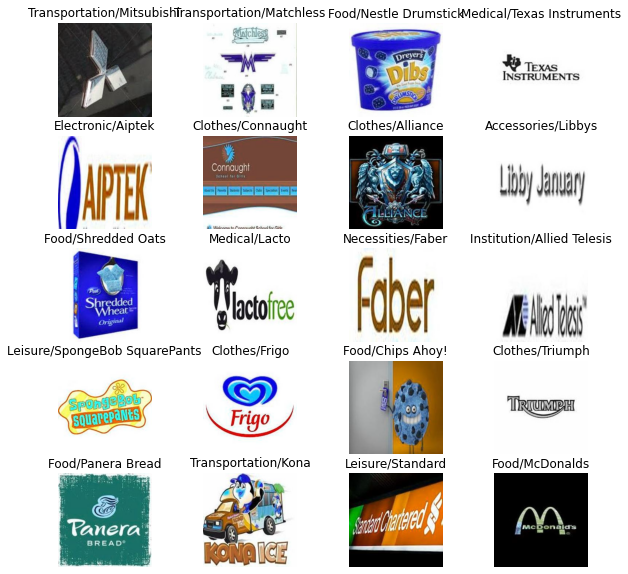

In [11]:
# Let's visualize some of the images:

fig = plt.figure(figsize=(10, 10))
i = 1
for row in df.sample(20).itertuples(index=False):
    ax = fig.add_subplot(5, 4, i)

    path = p.joinpath(*row)
    image = cv2.imread(str(path))
    plt.imshow(image)
    plt.title(f"{row[0]}/{row[1]}")
    plt.axis("off")

    i += 1
plt.show()

# Color Analysis

In [12]:
# Let's discover the most common colors used in the images
# (Adapted from https://towardsdatascience.com/finding-most-common-colors-in-python-47ea0767a06a)


from sklearn.cluster import KMeans


def most_common_colors(image: np.ndarray, n: int = 3) -> np.ndarray:
    k_means = KMeans(n_clusters=n)
    k_means.fit(image.reshape(-1, 3))
    return k_means.cluster_centers_


def palette(clusters: np.ndarray, height: int = 50, width: int = 300) -> np.ndarray:
    palette = np.zeros((height, width, 3), np.uint8)
    steps = width / clusters.shape[0]
    for i, centers in enumerate(clusters):
        palette[:, int(i * steps) : (int((i + 1) * steps)), :] = centers
    return palette

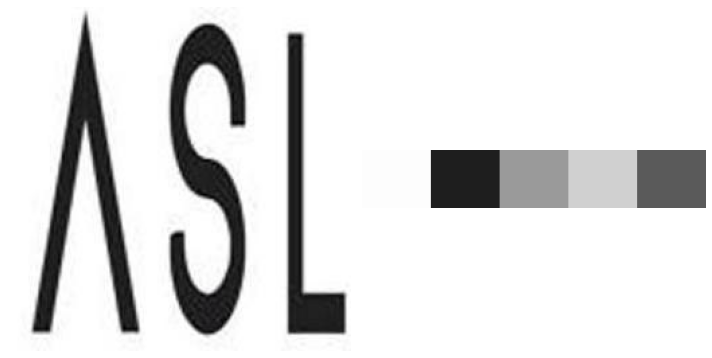

In [13]:
path = p.joinpath(*tuple(df.sample(1).iloc[0]))
image = cv2.imread(str(path))

colors = most_common_colors(image, n=5)
color_palette = palette(colors)

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(image)
ax[0].axis("off")
ax[1].imshow(color_palette)
ax[1].axis("off")
fig.tight_layout()

plt.show()

In [14]:
# Now Let's find if the average colors differ between image groups


def concat_images(df: pd.DataFrame) -> np.array:
    def images():
        for row in df.itertuples(index=False):
            path = p.joinpath(*row)
            image = cv2.imread(str(path))
            yield image

    return np.concatenate(pd.Series(images()))

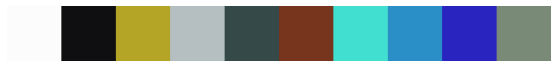

In [16]:
# Average color in an image sample

im = concat_images(df.sample(20))
im = im.reshape(-1, 3)

colors = most_common_colors(im, n=10)
color_palette = palette(colors, width=500)

plt.figure(figsize=(20, 1))
plt.imshow(color_palette)
plt.axis("off")
plt.show()

Now let's run this on image samples from every type

Sampling 1% of images from each type

In [21]:
types = df["type"].unique()

color_df = pd.DataFrame(columns=["type", "colors"])

for image_type in types:
    im = concat_images(df[df["type"] == image_type].sample(frac=0.01))
    im = im.reshape(-1, 3)

    colors = most_common_colors(im, n=10)

    color_df = color_df.append(
        {"type": image_type, "colors": colors}, ignore_index=True
    )

color_df

,type,colors
0,Accessories,"[[252.21456274079816, 252.53742736227522, 252...."
1,Clothes,"[[92.25001559062493, 103.84624917570468, 109.3..."
2,Cosmetic,"[[158.75587416853722, 167.00120533920267, 173...."
3,Electronic,"[[95.50752913138392, 94.90912209950234, 72.862..."
4,Food,"[[190.35276980511034, 211.0195623390676, 222.0..."
5,Institution,"[[251.49594899806135, 252.2670144417231, 251.7..."
6,Leisure,"[[217.51932651512485, 174.17333161651075, 74.6..."
7,Medical,"[[252.41521477903254, 252.94894816098545, 252...."
8,Necessities,"[[252.07870443871104, 252.68833609504287, 252...."
9,Transportation,"[[201.21224694752814, 205.0055984284083, 206.6..."


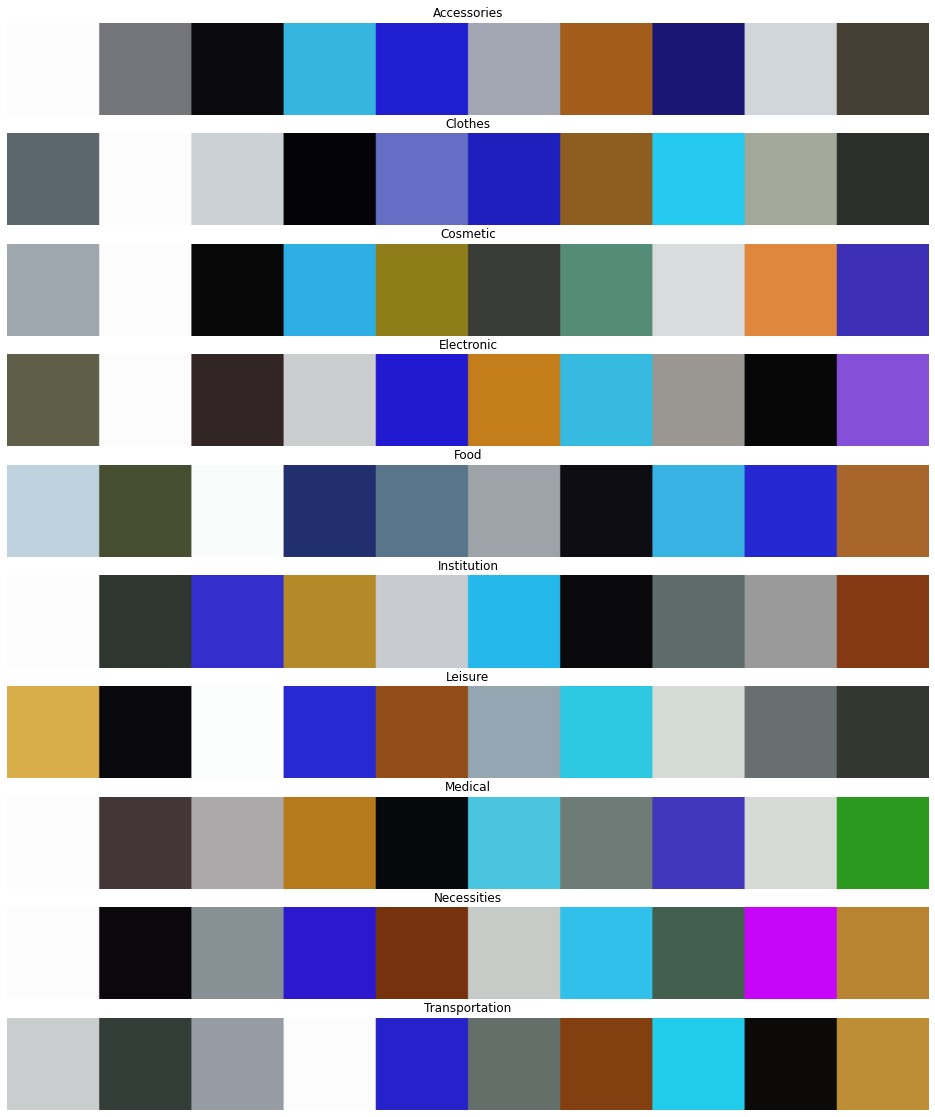

In [26]:

fix, ax = plt.subplots(len(types), 1, figsize=(20, 2 * len(types)))

i = 0
for row in color_df.itertuples():
    color_palette = palette(row.colors, width=500)

    ax[i].imshow(color_palette)
    ax[i].axis("off")
    ax[i].set_title(row.type)
    
    i+=1

plt.show()

# What shapes are the logos?

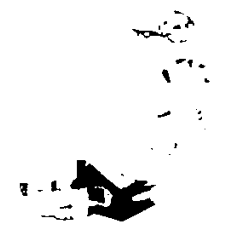

In [72]:
row = df.sample(1).iloc[0]
path = p.joinpath(*row)
image = cv2.imread(str(path))
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = cv2.GaussianBlur(image, (5,5), 0)
image = cv2.threshold(image, 60, 255, cv2.THRESH_BINARY)[1]

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

In [74]:
from skimage import measure

contours = measure.find_contours(image)
